# Classification problem

In [1]:
# basic data manuplation libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# aux libs created
from Classification import evaluation as evl
from Classification import modeling as ml
from Classification import feature_selection as fs

# show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

# remove warnings from outputs
import warnings
warnings.filterwarnings('ignore')

# path facilitators
import os
pwd = os.getcwd()
data_path = pwd + '/data/'
file_name_prefix = '1CB_'

# Binary Classification Example

To show how to do a classification we are using the [bank-marketing](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&qualities.NumberOfInstances=between_10000_100000&qualities.NumberOfFeatures=between_10_100&id=1461) datase from [openml](https://www.openml.org/). <br>
In this dataset we have data related with a marketing campaign to get subscription for a bank product called 'bank term deposit'.  <br>
The goal is to predict if the client will subscribe a term deposit or not.

In [2]:
# upload credit-g data from openml
import openml
dataset = openml.datasets.get_dataset('bank-marketing')
df, _, _, col_names = dataset.get_data(dataset_format="dataframe")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Class
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261.0,1,-1.0,0.0,unknown,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151.0,1,-1.0,0.0,unknown,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76.0,1,-1.0,0.0,unknown,1
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92.0,1,-1.0,0.0,unknown,1
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198.0,1,-1.0,0.0,unknown,1


In [3]:
print('Shape of the complete dataset (rows, columns):',df.shape)
df.info()

Shape of the complete dataset (rows, columns): (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      45211 non-null  uint8   
 1   V2      45211 non-null  category
 2   V3      45211 non-null  category
 3   V4      45211 non-null  category
 4   V5      45211 non-null  category
 5   V6      45211 non-null  float64 
 6   V7      45211 non-null  category
 7   V8      45211 non-null  category
 8   V9      45211 non-null  category
 9   V10     45211 non-null  uint8   
 10  V11     45211 non-null  category
 11  V12     45211 non-null  float64 
 12  V13     45211 non-null  uint8   
 13  V14     45211 non-null  float64 
 14  V15     45211 non-null  float64 
 15  V16     45211 non-null  category
 16  Class   45211 non-null  category
dtypes: category(10), float64(4), uint8(3)
memory usage: 1.9 MB


### Step 1: Separate train and test set

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)
df_train['binary_class'] = df_train['Class'].map({'1': 0, '2': 1})

In [5]:
evl.print_df_target_proportions(df_train, target='binary_class')

shape:  (36168, 18)
Proportion of 0:  0.8831840300818403
Proportion of 1:  0.11681596991815969


### Step 2: Check initial models potential

In [6]:
# prepare X and y
X_train = df_train.drop(['Class','binary_class'], axis=1)[['V1','V6','V10','V12','V13','V14','V15']]
y_train = df_train['binary_class']

# upload models
from sklearn.naive_bayes import GaussianNB
NaiveBayes = GaussianNB()
from sklearn.linear_model import LogisticRegression
LogisticRegression = LogisticRegression(random_state=4)
from sklearn.tree import DecisionTreeClassifier
DecisionTree = DecisionTreeClassifier(max_depth=10 ,random_state=4)
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(max_depth=10, n_estimators=7, random_state=0)
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(verbose=-1)

model_type_names = ['NaiveBayes', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM'] # 
model_types_obj = [NaiveBayes,  LogisticRegression, DecisionTree, RandomForest, lgbm] # 

df_models = ml.evaluate_model_type(X_train, y_train, model_type_names, model_types_obj)
df_models

Performing cross validation for:  NaiveBayes
Performing cross validation for:  LogisticRegression
Performing cross validation for:  DecisionTree
Performing cross validation for:  RandomForest
Performing cross validation for:  LightGBM


,model,aucpr_train,aucpr_val,f1_train,f1_val,time
0,NaiveBayes,0.351650,0.355104,0.382064,0.382849,0.009490
1,LogisticRegression,0.349123,0.352448,0.240893,0.240673,0.181688
2,DecisionTree,0.683683,0.418416,0.598467,0.442154,0.072075
3,RandomForest,0.688918,0.481848,0.549690,0.380527,0.135651
4,LightGBM,0.697095,0.526372,0.573442,0.463114,0.465117


TO DO: Explain what does this result mean

### Step 3: Perform Hyper-parameter Search

In [7]:
# sample_pos_weight = number of negative samples / number of positive samples
# num_leaves = 2^(max_depth)

In [8]:
# Instantiate the model
model = lgb.LGBMClassifier(objective='binary', boosting='gbdt', metric='logloss', random_state=42, n_jobs=3, verbose=-1)
# perform hiper parameter search
param_grid = {
        "data_sample_strategy": ['bagging','goss'],
        "n_estimators": [3, 5, 7, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "max_depth": [4, 7, 9, 10],  # max depth of a tree
        "scale_pos_weight": [1,2,3,4], # weight of the positive observations
        "subsample": [0.5, 0.7, 1],  # Fraction of observations to be random sampled for each tree
        "feature_fraction": [0.5, 0.7, 1],  # Fraction of features to be random sampled for each tree
        "num_leaves": [3, 4, 5, 9, 10, 15, 30], # maximum number of leaves 
        "reg_alpha": [0, 1, 2, 5, 10, 50],  # L1 regularization term
        "reg_lambda": [0, 1, 2, 5, 10, 50],  # L2 regularization term
        "gamma": [0, 1, 2, 5, 10],  #  Minimum loss reduction required to make a split - can be used as extra regularization in large parameter grids
}
search = ml.perform_hiperparameter_search(X_train, y_train, param_grid, model=model)

In [9]:
df_search = ml.analyse_search_results(search)
df_search.to_pickle(data_path + file_name_prefix + 'df_search.pkl')

----- Top 10 performance on validation set -----
     mean_train_score  mean_test_score  round_test_score  rank_test_score  \
4            0.516924         0.497739              0.50                3   
17           0.526574         0.498981              0.50                2   
277          0.536380         0.501413              0.50                1   
66           0.498594         0.485696              0.49               11   
150          0.502482         0.485724              0.49               10   
201          0.509717         0.488581              0.49                6   
248          0.510239         0.488571              0.49                7   
61           0.509697         0.487775              0.49                9   
99           0.513012         0.488551              0.49                8   
263          0.517380         0.490454              0.49                4   

     diff_train_test  
4           0.019185  
17          0.027593  
277         0.034967  
66         

    round_test_score  diff_train_test
21              0.50         0.019185
20              0.49         0.012898
19              0.48         0.008870
18              0.47         0.003621
17              0.46         0.005621
16              0.45         0.002475
15              0.44         0.002415
14              0.43         0.002308
13              0.42         0.000107
12              0.41         0.002015


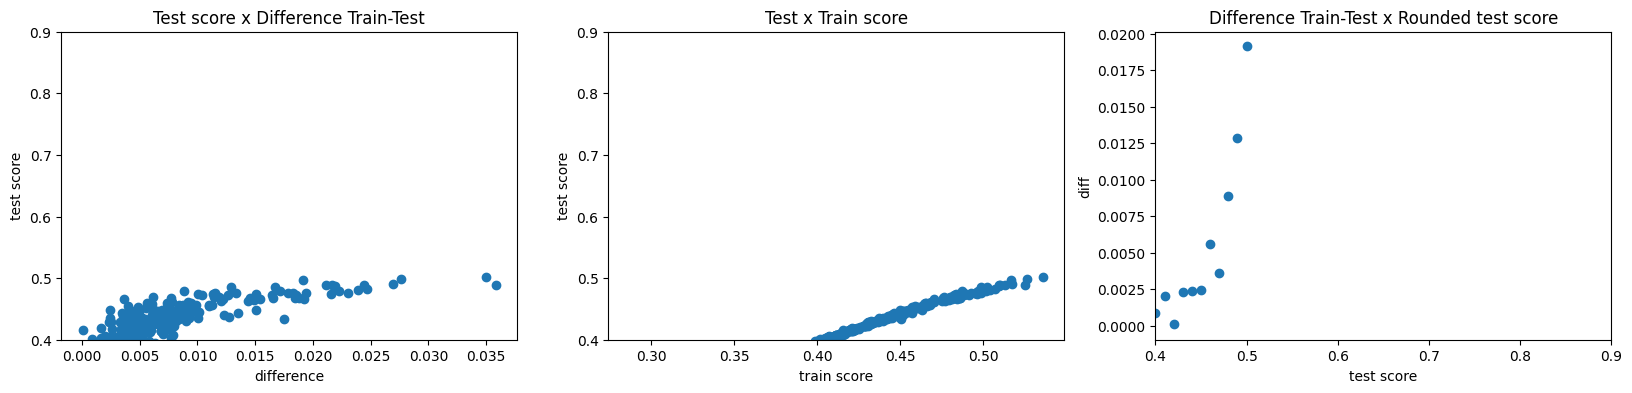

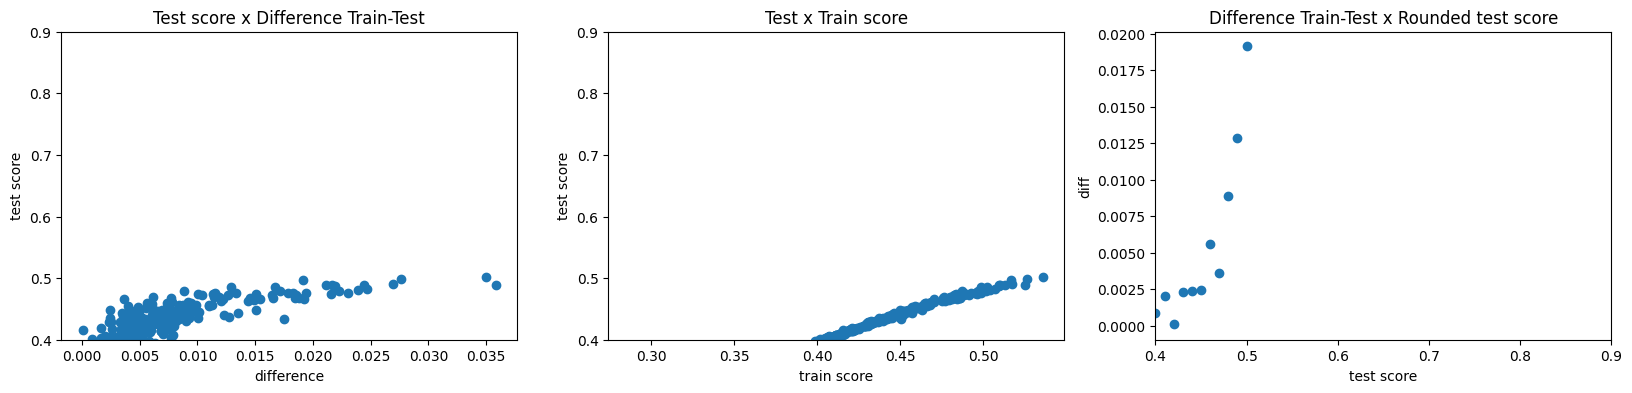

In [14]:
ml.plot_search_distributions(df_search, figsize=(20, 4))

In [10]:
df_search[(df_search.round_test_score == 0.50)].sort_values('diff_train_test').reset_index().head(5)

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_feature_fraction,param_data_sample_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,diff_train_test,diff_test_train,round_test_score
0,4,0.094467,0.019061,0.003153,0.000561,1,4,1,2,15,10,10,0.3,1,0.7,bagging,"{'subsample': 1, 'scale_pos_weight': 4, 'reg_l...",0.505559,0.489742,0.457945,0.532674,0.524661,0.485473,0.507393,0.497728,0.488270,0.487945,0.497739,0.020207,3,0.523617,0.519018,0.516902,0.515021,0.516285,0.515382,0.528288,0.515647,0.511464,0.507620,0.516924,0.005502,0.019185,-0.019185,0.5
1,17,0.114639,0.018965,0.002844,0.000259,1,2,10,2,30,10,7,0.2,5,0.5,goss,"{'subsample': 1, 'scale_pos_weight': 2, 'reg_l...",0.509051,0.491249,0.485329,0.506964,0.503179,0.470827,0.514421,0.493407,0.500935,0.514447,0.498981,0.013168,2,0.524531,0.528710,0.529281,0.525075,0.524064,0.526835,0.522424,0.531088,0.528833,0.524901,0.526574,0.002649,0.027593,-0.027593,0.5
2,277,0.113194,0.011486,0.003107,0.000760,0.7,3,1,1,30,10,10,0.2,0,0.7,goss,"{'subsample': 0.7, 'scale_pos_weight': 3, 'reg...",0.512423,0.497153,0.474717,0.541768,0.518781,0.491582,0.493937,0.484858,0.492874,0.506033,0.501413,0.018174,1,0.537386,0.532847,0.537464,0.537310,0.536866,0.535336,0.539161,0.541285,0.530189,0.535952,0.536380,0.002953,0.034967,-0.034967,0.5


In [12]:
# Selectiong the chosed parameters
dict_params = df_search[(df_search.round_test_score == 0.5)].sort_values('diff_train_test').reset_index().params[0]
print("Selected params: ",dict_params)

Selected params:  {'subsample': 1, 'scale_pos_weight': 4, 'reg_lambda': 1, 'reg_alpha': 2, 'num_leaves': 15, 'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 1, 'feature_fraction': 0.7, 'data_sample_strategy': 'bagging'}


### Step 4: Train model with best parameters

### Step 5: Evaluate results